# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

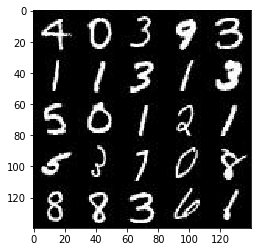

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

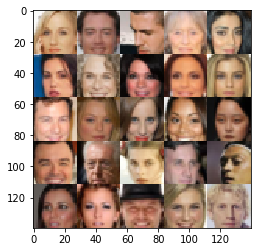

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [11]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        
        #input layer: 
        #28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu_1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu_1, 128, 5, strides=2, padding='same')
        bat_norm_2 = tf.layers.batch_normalization(x2, training=True) 
        relu_2 = tf.maximum(alpha * bat_norm_2, bat_norm_2)
        #7x7x128
        
        x3 = tf.layers.conv2d(relu_2, 256, 5, strides=2, padding='same')
        bat_norm_3 = tf.layers.batch_normalization(x3, training=True)
        relu_3 = tf.maximum(alpha * bat_norm_3, bat_norm_3)
        #4x4x256
        
        flatten = tf.reshape(relu_3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    if is_train == True:
        reuse=False
    else:
        reuse=True
        
    #Fully connected
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #28x28x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        #28x28x3
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
#     g_model = generator(input_z, out_channel_dim, is_train=True ,alpha=alpha)
#     d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
#     d_model_fake, d_logits_fake = discriminator(g_model, reuse=False, alpha=alpha)
    
#     d_loss_real = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
#     d_loss_fake = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
#     g_loss = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
#     d_loss = d_loss_real + d_loss_fake
    
#     return d_loss, g_loss
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
   
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):        
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         print_every=10, show_every=100, alpha=0.1):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0
    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    


    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=alpha)

    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate/2, input_real: batch_images})
                sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate/2, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    #gen_samples = sess.run(
                    #               generator(input_z, 3, reuse=True),
                    #               feed_dict={input_z: sample_z})
                    
                    #samples.append(gen_samples)
                    #_ = view_samples(-1, samples, 5, 10, figsize=figsize)
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    #plt.show()
                    
                    
        #saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7729... Generator Loss: 0.4070
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 1.5944
Epoch 1/2... Discriminator Loss: 2.1937... Generator Loss: 2.0238
Epoch 1/2... Discriminator Loss: 1.8529... Generator Loss: 0.2054
Epoch 1/2... Discriminator Loss: 1.2094... Generator Loss: 0.4758
Epoch 1/2... Discriminator Loss: 0.7861... Generator Loss: 1.5157
Epoch 1/2... Discriminator Loss: 0.8016... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 0.4381... Generator Loss: 1.4646
Epoch 1/2... Discriminator Loss: 0.3639... Generator Loss: 1.4681
Epoch 1/2... Discriminator Loss: 0.1604... Generator Loss: 2.5511


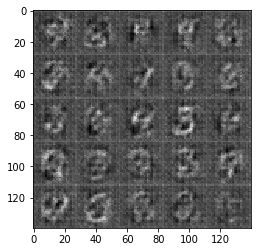

Epoch 1/2... Discriminator Loss: 0.1042... Generator Loss: 3.0644
Epoch 1/2... Discriminator Loss: 0.0906... Generator Loss: 4.1618
Epoch 1/2... Discriminator Loss: 0.1475... Generator Loss: 2.8508
Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 2.2376
Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 0.4568
Epoch 1/2... Discriminator Loss: 0.5762... Generator Loss: 1.1076
Epoch 1/2... Discriminator Loss: 3.0710... Generator Loss: 0.0572
Epoch 1/2... Discriminator Loss: 2.3701... Generator Loss: 0.1242
Epoch 1/2... Discriminator Loss: 0.5245... Generator Loss: 3.7937
Epoch 1/2... Discriminator Loss: 0.4441... Generator Loss: 2.1890


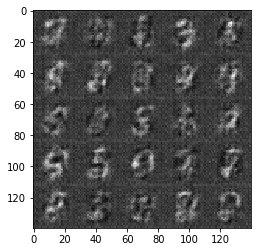

Epoch 1/2... Discriminator Loss: 0.1806... Generator Loss: 3.5120
Epoch 1/2... Discriminator Loss: 0.7171... Generator Loss: 0.8273
Epoch 1/2... Discriminator Loss: 1.3722... Generator Loss: 5.8000
Epoch 1/2... Discriminator Loss: 0.3855... Generator Loss: 1.5433
Epoch 1/2... Discriminator Loss: 0.2211... Generator Loss: 2.1373
Epoch 1/2... Discriminator Loss: 0.5336... Generator Loss: 1.2769
Epoch 1/2... Discriminator Loss: 0.2675... Generator Loss: 2.2476
Epoch 1/2... Discriminator Loss: 0.2447... Generator Loss: 2.4003
Epoch 1/2... Discriminator Loss: 0.2466... Generator Loss: 2.8529
Epoch 1/2... Discriminator Loss: 0.2145... Generator Loss: 2.7001


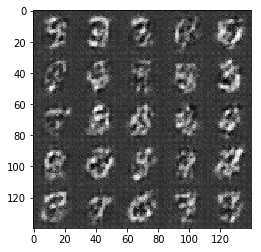

Epoch 1/2... Discriminator Loss: 0.1968... Generator Loss: 3.0232
Epoch 1/2... Discriminator Loss: 0.2370... Generator Loss: 1.9702
Epoch 1/2... Discriminator Loss: 0.5036... Generator Loss: 1.1162
Epoch 1/2... Discriminator Loss: 0.3824... Generator Loss: 2.3767
Epoch 1/2... Discriminator Loss: 0.3768... Generator Loss: 1.5416
Epoch 1/2... Discriminator Loss: 0.2611... Generator Loss: 1.8671
Epoch 1/2... Discriminator Loss: 0.2679... Generator Loss: 1.8527
Epoch 1/2... Discriminator Loss: 0.2101... Generator Loss: 2.3746
Epoch 1/2... Discriminator Loss: 0.1467... Generator Loss: 2.6495
Epoch 1/2... Discriminator Loss: 0.2808... Generator Loss: 1.6979


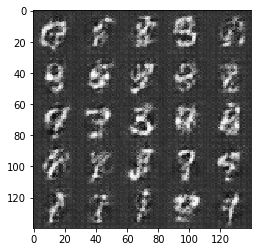

Epoch 1/2... Discriminator Loss: 0.4467... Generator Loss: 1.3089
Epoch 1/2... Discriminator Loss: 0.2504... Generator Loss: 1.9499
Epoch 1/2... Discriminator Loss: 0.2542... Generator Loss: 2.0143
Epoch 1/2... Discriminator Loss: 0.2694... Generator Loss: 1.8686
Epoch 1/2... Discriminator Loss: 0.2781... Generator Loss: 1.7645
Epoch 1/2... Discriminator Loss: 1.9223... Generator Loss: 7.5510
Epoch 2/2... Discriminator Loss: 0.4382... Generator Loss: 1.3134
Epoch 2/2... Discriminator Loss: 0.4842... Generator Loss: 1.2598
Epoch 2/2... Discriminator Loss: 0.3399... Generator Loss: 1.9881
Epoch 2/2... Discriminator Loss: 0.5204... Generator Loss: 1.1691


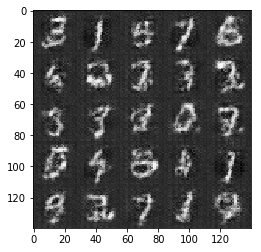

Epoch 2/2... Discriminator Loss: 2.4398... Generator Loss: 7.9893
Epoch 2/2... Discriminator Loss: 0.5515... Generator Loss: 1.3324
Epoch 2/2... Discriminator Loss: 0.5548... Generator Loss: 1.1659
Epoch 2/2... Discriminator Loss: 0.6113... Generator Loss: 1.0182
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 0.5415
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 0.7125
Epoch 2/2... Discriminator Loss: 0.5759... Generator Loss: 1.0269
Epoch 2/2... Discriminator Loss: 0.7544... Generator Loss: 0.8030
Epoch 2/2... Discriminator Loss: 0.6661... Generator Loss: 0.9289
Epoch 2/2... Discriminator Loss: 0.7943... Generator Loss: 0.7662


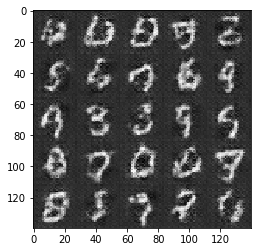

Epoch 2/2... Discriminator Loss: 4.2337... Generator Loss: 1.3809
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 0.8471
Epoch 2/2... Discriminator Loss: 0.6088... Generator Loss: 1.1894
Epoch 2/2... Discriminator Loss: 0.6055... Generator Loss: 1.0574
Epoch 2/2... Discriminator Loss: 0.5476... Generator Loss: 1.1458
Epoch 2/2... Discriminator Loss: 0.3163... Generator Loss: 1.9322
Epoch 2/2... Discriminator Loss: 0.5259... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 0.5404... Generator Loss: 1.1442
Epoch 2/2... Discriminator Loss: 0.5746... Generator Loss: 2.6790
Epoch 2/2... Discriminator Loss: 0.4208... Generator Loss: 1.5686


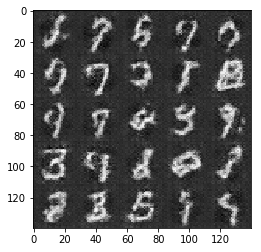

Epoch 2/2... Discriminator Loss: 0.4788... Generator Loss: 1.2518
Epoch 2/2... Discriminator Loss: 0.6838... Generator Loss: 0.9011
Epoch 2/2... Discriminator Loss: 0.1974... Generator Loss: 2.5014
Epoch 2/2... Discriminator Loss: 0.2451... Generator Loss: 2.1674
Epoch 2/2... Discriminator Loss: 0.4177... Generator Loss: 1.3652
Epoch 2/2... Discriminator Loss: 0.7361... Generator Loss: 1.2551
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 0.6248
Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 0.6779
Epoch 2/2... Discriminator Loss: 0.6012... Generator Loss: 1.1168
Epoch 2/2... Discriminator Loss: 0.3263... Generator Loss: 2.4069


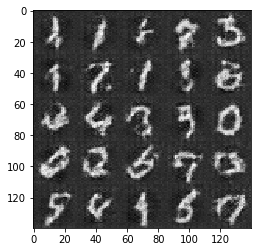

Epoch 2/2... Discriminator Loss: 0.9176... Generator Loss: 0.6431
Epoch 2/2... Discriminator Loss: 0.5019... Generator Loss: 1.5187
Epoch 2/2... Discriminator Loss: 0.6535... Generator Loss: 0.8948
Epoch 2/2... Discriminator Loss: 0.2676... Generator Loss: 2.8371
Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 0.6741
Epoch 2/2... Discriminator Loss: 0.4981... Generator Loss: 1.2325
Epoch 2/2... Discriminator Loss: 0.3133... Generator Loss: 1.7935
Epoch 2/2... Discriminator Loss: 0.3598... Generator Loss: 1.4316
Epoch 2/2... Discriminator Loss: 1.9253... Generator Loss: 0.1959
Epoch 2/2... Discriminator Loss: 2.6158... Generator Loss: 0.1014


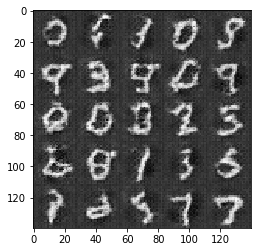

Epoch 2/2... Discriminator Loss: 0.5418... Generator Loss: 1.3764
Epoch 2/2... Discriminator Loss: 0.5212... Generator Loss: 1.1681
Epoch 2/2... Discriminator Loss: 0.5794... Generator Loss: 1.0829


In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5884... Generator Loss: 0.2913
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.6884... Generator Loss: 0.2313
Epoch 1/1... Discriminator Loss: 0.5672... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 1.5181
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 0.6979


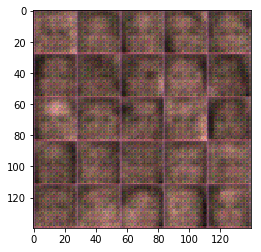

Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 1.9557
Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 6.1469
Epoch 1/1... Discriminator Loss: 1.7745... Generator Loss: 0.2436
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.3510
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.5454
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 3.4239


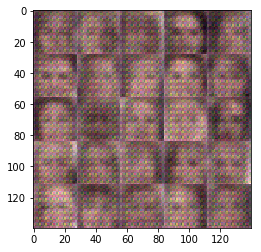

Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 0.8923


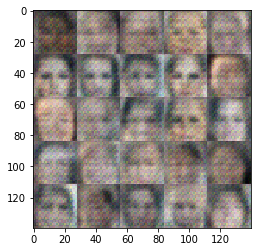

Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 1.4905
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.0923
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.5766


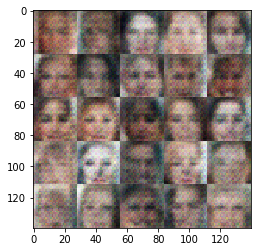

Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 1.3068
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 1.4068
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 0.5471... Generator Loss: 2.1274
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.4234


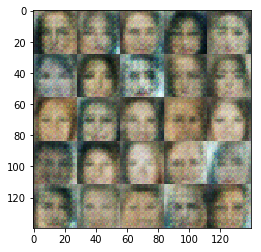

Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 0.5839... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 2.2806
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.0980


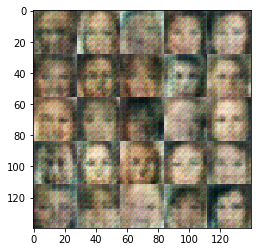

Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 0.6781... Generator Loss: 1.6826
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.3837
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.8928
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 1.6137
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.6461


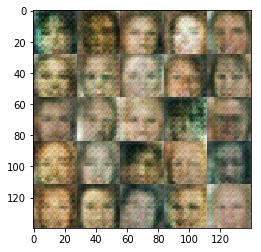

Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.5638
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.4208
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 2.4127
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.5304
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 1.3376
Epoch 1/1... Discriminator Loss: 0.7304... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 1.7463


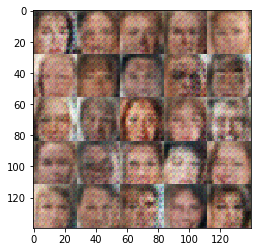

Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 0.6269... Generator Loss: 3.6266
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 1.3511
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 0.8601


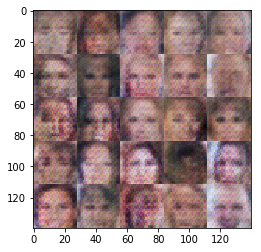

Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.4535
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 1.2923
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.5892
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.3132
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 0.6871... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.7005... Generator Loss: 0.2504


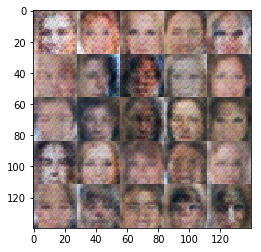

Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.9985
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.3750
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 2.8082
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.4822
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.3134
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.4040


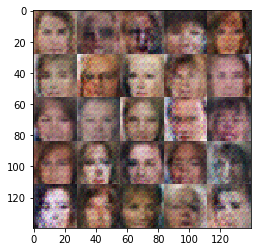

Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 1.3977
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.4084
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.4077
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.3734
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 2.8315
Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 1.0957


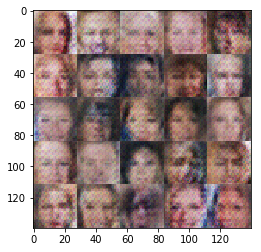

Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 1.4750
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.4120
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.6983
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.8123... Generator Loss: 0.2419
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.3263
Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 0.2725
Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 2.7490


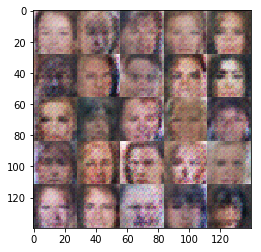

Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 2.2874
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.3610
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 1.6630
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.3354
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.3627
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 1.2871
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 1.7843
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.4895
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.3917


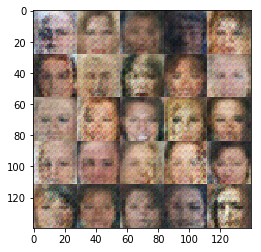

Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 2.0242
Epoch 1/1... Discriminator Loss: 0.4138... Generator Loss: 2.0283
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.4243
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 4.5446
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 1.4698
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 0.3004... Generator Loss: 2.4965
Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 1.5998


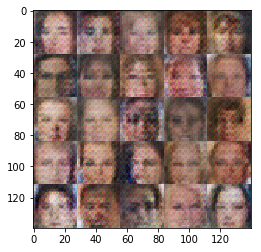

Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 0.2874... Generator Loss: 2.5888
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 3.1551
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.3065
Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 1.4268
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.3465
Epoch 1/1... Discriminator Loss: 0.2768... Generator Loss: 3.5472
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 0.8143


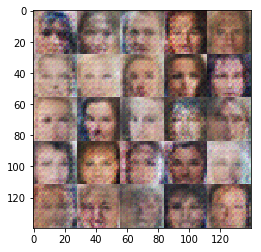

Epoch 1/1... Discriminator Loss: 0.2179... Generator Loss: 3.0877
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 1.8849
Epoch 1/1... Discriminator Loss: 1.7047... Generator Loss: 0.2736
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 2.2626
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.6142... Generator Loss: 0.2860
Epoch 1/1... Discriminator Loss: 0.4097... Generator Loss: 2.7072
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.5408


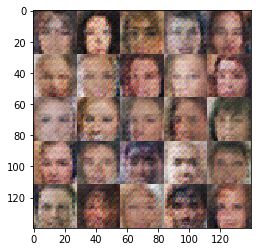

Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 0.3232... Generator Loss: 5.1401
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.3508
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.4510
Epoch 1/1... Discriminator Loss: 0.2634... Generator Loss: 2.1083
Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 0.3379... Generator Loss: 1.6470
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.3269
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 0.7699


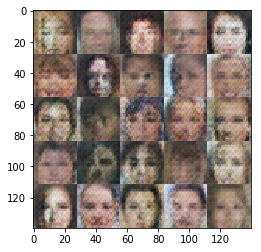

Epoch 1/1... Discriminator Loss: 0.3136... Generator Loss: 2.3760
Epoch 1/1... Discriminator Loss: 0.6679... Generator Loss: 6.1653
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.3026
Epoch 1/1... Discriminator Loss: 0.6450... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 0.3168... Generator Loss: 1.9463
Epoch 1/1... Discriminator Loss: 1.6567... Generator Loss: 0.2745
Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 1.8920
Epoch 1/1... Discriminator Loss: 0.2068... Generator Loss: 5.4292


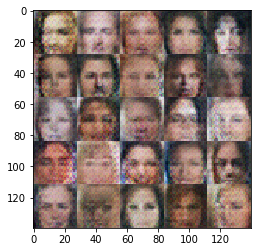

Epoch 1/1... Discriminator Loss: 1.6614... Generator Loss: 0.2782
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.3055
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 1.9546
Epoch 1/1... Discriminator Loss: 0.1765... Generator Loss: 4.5481
Epoch 1/1... Discriminator Loss: 1.8407... Generator Loss: 0.2174
Epoch 1/1... Discriminator Loss: 0.2922... Generator Loss: 2.5262
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.4535
Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 1.3686
Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 2.1772
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.4769


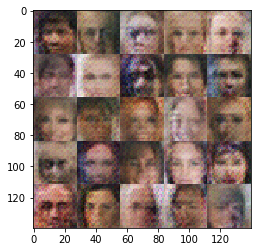

Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 2.9997
Epoch 1/1... Discriminator Loss: 0.4616... Generator Loss: 1.6626
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.6373... Generator Loss: 0.2782
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.3954
Epoch 1/1... Discriminator Loss: 0.6357... Generator Loss: 1.3218
Epoch 1/1... Discriminator Loss: 1.7709... Generator Loss: 0.3143
Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 3.9067


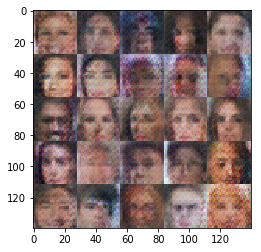

Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 1.5700
Epoch 1/1... Discriminator Loss: 0.3109... Generator Loss: 1.6193
Epoch 1/1... Discriminator Loss: 1.8706... Generator Loss: 0.2675
Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 0.1390... Generator Loss: 3.4137
Epoch 1/1... Discriminator Loss: 0.3006... Generator Loss: 1.5405
Epoch 1/1... Discriminator Loss: 0.7028... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 0.8734


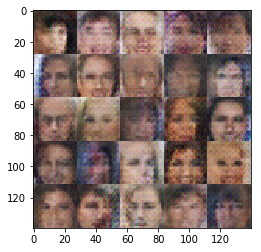

Epoch 1/1... Discriminator Loss: 2.2530... Generator Loss: 0.1462
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.3339
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 1.1590
Epoch 1/1... Discriminator Loss: 0.4326... Generator Loss: 2.8029
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 2.8624
Epoch 1/1... Discriminator Loss: 1.7867... Generator Loss: 0.2416
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.4290
Epoch 1/1... Discriminator Loss: 0.2140... Generator Loss: 4.7826


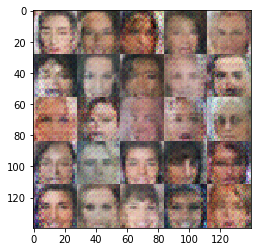

Epoch 1/1... Discriminator Loss: 2.8756... Generator Loss: 0.0741
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.3960
Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.3410
Epoch 1/1... Discriminator Loss: 0.2372... Generator Loss: 3.3085
Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 1.2956
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.4313
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 1.4531
Epoch 1/1... Discriminator Loss: 0.8212... Generator Loss: 9.6457
Epoch 1/1... Discriminator Loss: 0.3669... Generator Loss: 1.4949


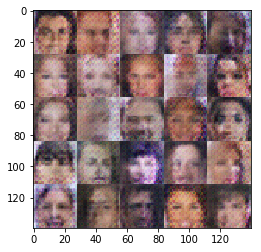

Epoch 1/1... Discriminator Loss: 1.9833... Generator Loss: 0.2099
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 1.5736
Epoch 1/1... Discriminator Loss: 0.7054... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 0.5547... Generator Loss: 1.5861
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 0.0530... Generator Loss: 4.4172
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 0.3681... Generator Loss: 8.7526
Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 1.4485


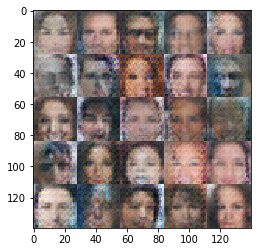

Epoch 1/1... Discriminator Loss: 1.8486... Generator Loss: 0.2143
Epoch 1/1... Discriminator Loss: 0.2490... Generator Loss: 11.6777
Epoch 1/1... Discriminator Loss: 0.2621... Generator Loss: 2.6042
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 6.1333
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 0.2643... Generator Loss: 2.9718
Epoch 1/1... Discriminator Loss: 0.1458... Generator Loss: 5.6054
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 0.5011... Generator Loss: 2.2410
Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 1.0485


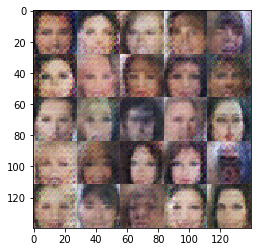

Epoch 1/1... Discriminator Loss: 0.3368... Generator Loss: 2.3868
Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 5.5329
Epoch 1/1... Discriminator Loss: 0.1628... Generator Loss: 3.7654
Epoch 1/1... Discriminator Loss: 0.1558... Generator Loss: 3.2002
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 0.0465... Generator Loss: 7.4857
Epoch 1/1... Discriminator Loss: 0.6956... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 0.0705... Generator Loss: 4.8356
Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.2723


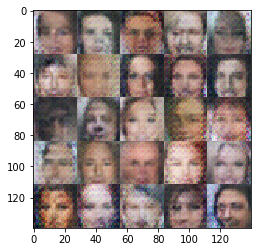

Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 0.1126... Generator Loss: 3.1335
Epoch 1/1... Discriminator Loss: 0.6222... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 0.1012... Generator Loss: 3.9621
Epoch 1/1... Discriminator Loss: 0.1397... Generator Loss: 3.4292
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 6.9484
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 0.1605... Generator Loss: 7.9291
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.3178


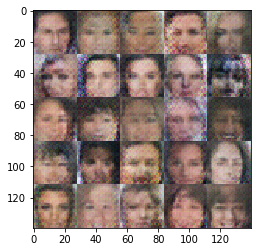

Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 0.2751... Generator Loss: 2.8558
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.3952
Epoch 1/1... Discriminator Loss: 1.8701... Generator Loss: 0.2982
Epoch 1/1... Discriminator Loss: 0.1069... Generator Loss: 3.9145
Epoch 1/1... Discriminator Loss: 0.1461... Generator Loss: 6.8693
Epoch 1/1... Discriminator Loss: 0.1437... Generator Loss: 11.9870
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 3.2977... Generator Loss: 0.0488


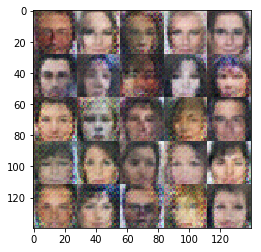

Epoch 1/1... Discriminator Loss: 0.1258... Generator Loss: 9.7733
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 1.4608
Epoch 1/1... Discriminator Loss: 2.0654... Generator Loss: 0.1814
Epoch 1/1... Discriminator Loss: 0.2164... Generator Loss: 6.8077
Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 1.9324
Epoch 1/1... Discriminator Loss: 0.0527... Generator Loss: 3.4564
Epoch 1/1... Discriminator Loss: 1.6357... Generator Loss: 0.3126
Epoch 1/1... Discriminator Loss: 1.9640... Generator Loss: 0.1934
Epoch 1/1... Discriminator Loss: 0.1417... Generator Loss: 7.0023
Epoch 1/1... Discriminator Loss: 0.2905... Generator Loss: 6.8320


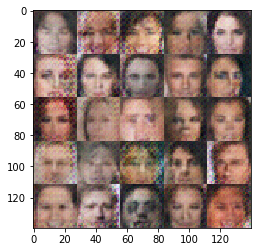

Epoch 1/1... Discriminator Loss: 0.1935... Generator Loss: 2.5172
Epoch 1/1... Discriminator Loss: 0.3817... Generator Loss: 1.4385
Epoch 1/1... Discriminator Loss: 0.1460... Generator Loss: 3.0421
Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 4.5291
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 0.2809... Generator Loss: 2.0755
Epoch 1/1... Discriminator Loss: 2.1070... Generator Loss: 0.1604
Epoch 1/1... Discriminator Loss: 0.1472... Generator Loss: 3.1220
Epoch 1/1... Discriminator Loss: 0.1764... Generator Loss: 4.5246
Epoch 1/1... Discriminator Loss: 0.0918... Generator Loss: 3.4450


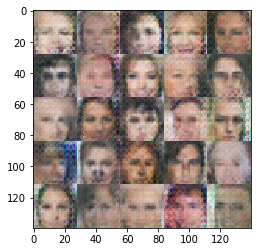

Epoch 1/1... Discriminator Loss: 0.1787... Generator Loss: 2.7248
Epoch 1/1... Discriminator Loss: 0.2539... Generator Loss: 2.4641
Epoch 1/1... Discriminator Loss: 0.5925... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 2.0323... Generator Loss: 0.1889
Epoch 1/1... Discriminator Loss: 2.0078... Generator Loss: 0.1727
Epoch 1/1... Discriminator Loss: 0.0807... Generator Loss: 3.4651


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.